# Semi offline Simple Pendulum Simulation 

## add to path 

In [1]:
import sys
from pathlib import Path

# Get the current notebook's directory
parent = Path().resolve()  # Current working directory (notebook's directory)
root = parent.parent.parent       # Go one level up

print("Current Directory:", parent)
print("Parent Directory:", root)

# Optionally append to sys.path
sys.path.append(str(root))


Current Directory: D:\mukul\Desktop\Unimelb\Masters\Capstone\Learning-Dynamic-Systems\indirect_identification\notebooks
Parent Directory: D:\mukul\Desktop\Unimelb\Masters\Capstone\Learning-Dynamic-Systems


# Sim

## Open loop

Number of samples: 1000


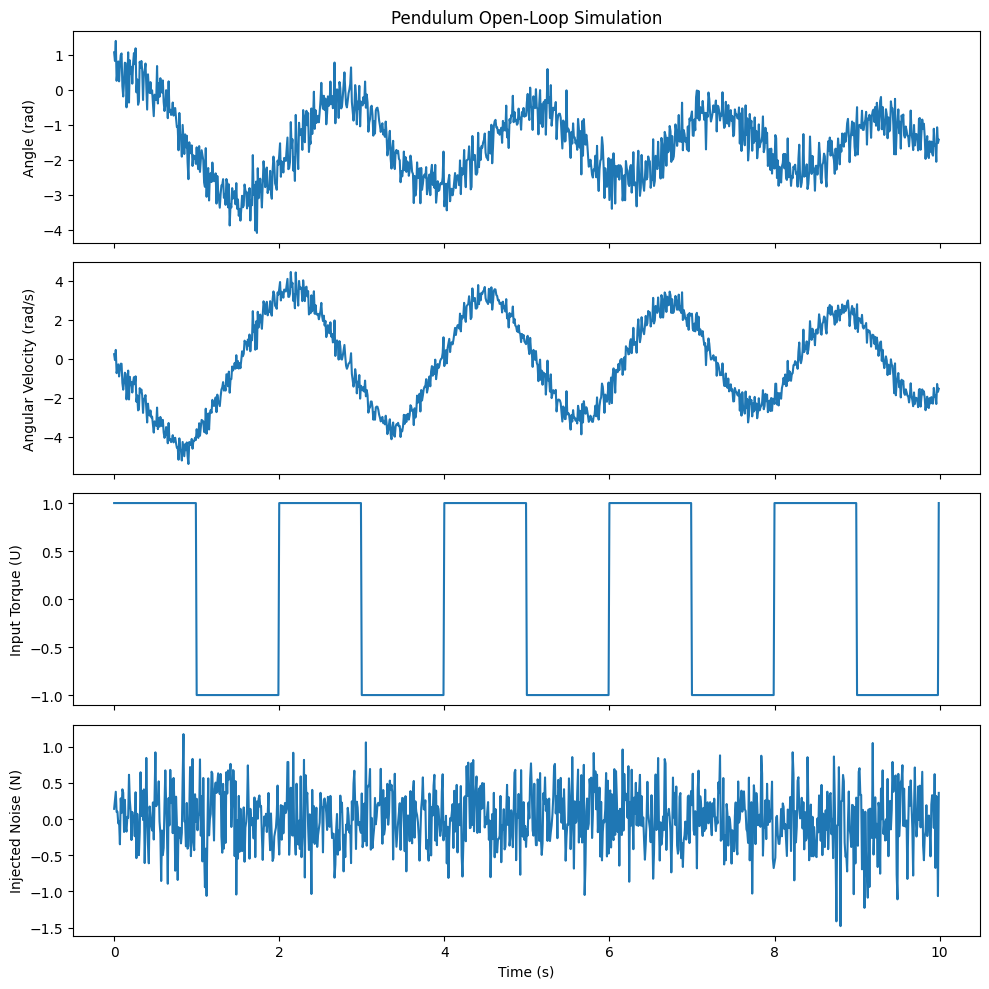

Y shape: (2, 1000) U shape: (1, 1000)


In [2]:
from sims.pendulum import Pendulum
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import cv2  # Only needed if you're using OpenCV windows

# Simulation settings
dt = 0.01
initial_state = np.array([np.pi/4, 0.0])
noise_std = 0.4
t = 10 # total simulation time in seconds
n_samples = int(np.ceil(t / dt))
print("Number of samples:", n_samples)

# Create the pendulum simulator
sim = Pendulum(
    dt=dt,
    initial_state=initial_state,
    plot_system=False,
    history_limit=200,
    noise_std=noise_std
)

# Input signal (sinusoidal input)
U = 1* signal.square(np.linspace(0, 10*np.pi, n_samples))

# Simulation function
def simulate_open_loop(n_samples, U=None, noise_std=noise_std, sim=sim):
    Y = np.zeros((2, n_samples))
    N = np.random.normal(0, noise_std, n_samples)

    if U is None:
        U = np.zeros(n_samples)

    for i in range(n_samples):
        _, _, Y[:, i] = sim.step(u=U[i], t=i * dt, full_state=True)

    return Y, U, N

# Plotting function with time axis
def plot_results(Y, U, N, dt):
    n_samples = Y.shape[1]
    time = np.arange(n_samples) * dt

    fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

    axs[0].plot(time, Y[0])
    axs[0].set_ylabel('Angle (rad)')
    axs[0].set_title('Pendulum Open-Loop Simulation')

    axs[1].plot(time, Y[1])
    axs[1].set_ylabel('Angular Velocity (rad/s)')

    axs[2].plot(time, U)
    axs[2].set_ylabel('Input Torque (U)')

    axs[3].plot(time, N)
    axs[3].set_ylabel('Injected Noise (N)')
    axs[3].set_xlabel('Time (s)')

    plt.tight_layout()
    plt.show()

# Run the simulation and plot
Y, U, N = simulate_open_loop(n_samples, U, noise_std=noise_std, sim=sim)
plot_results(Y, U, N, dt)

# Check shapes
U = U.reshape(1, -1)
print("Y shape:", Y.shape, "U shape:", U.shape)

# Clean up any OpenCV windows (optional)
cv2.destroyAllWindows()


In [3]:
# k = 4  # Downsample by factor of 10
# Y_ds = np.ascontiguousarray(Y[:, ::k])
# U_ds = np.ascontiguousarray(U[:, ::k])
# time_ds = np.arange(Y_ds.shape[1]) * (dt * k)

# print("Downsampled shapes:", Y_ds.shape, U_ds.shape)

# # Optional: plot downsampled results
# def plot_downsampled_results(Y, U, time):
#     fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

#     axs[0].plot(time, Y[0])
#     axs[0].set_ylabel('Angle (rad)')
#     axs[0].set_title('Downsampled Simulation')

#     axs[1].plot(time, Y[1])
#     axs[1].set_ylabel('Angular Velocity (rad/s)')

#     axs[2].plot(time, U.flatten())
#     axs[2].set_ylabel('Input Torque (U)')

#     plt.tight_layout()
#     plt.show()

# plot_downsampled_results(Y_ds, U_ds, time_ds) 

# Y,U = Y_ds, U_ds

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_sps_points(blue_pts, lse, mode='pca', c_vals=None, d_vals=None):
    """
    Plot SPS region based on (a, b, c, d) points.

    Parameters:
        blue_pts (np.ndarray): Points inside the region (N, 4).
        red_pts (np.ndarray): Points outside the region (M, 4).
        lse (np.ndarray): The LSE point (4,).
        mode (str): 'pca' or 'slices'.
        c_vals (list or np.ndarray): List of c values (required for 'slices' mode).
        d_vals (list or np.ndarray): List of d values (required for 'slices' mode).
    """
    if mode == 'pca':
        # Combine and apply PCA
        all_pts = np.vstack([blue_pts,])
        labels = np.array([1]*len(blue_pts) )
        pca = PCA(n_components=2)
        pts_2d = pca.fit_transform(all_pts)
        lse_2d = pca.transform([lse])

        plt.figure(figsize=(8, 6))
        plt.scatter(pts_2d[labels == 1, 0], pts_2d[labels == 1, 1], color='blue', label='Inside SPS', s=5)
        # plt.scatter(pts_2d[labels == 0, 0], pts_2d[labels == 0, 1], color='red', label='Outside SPS', alpha=0.1, s=5)
        plt.scatter(lse_2d[0, 0], lse_2d[0, 1], color='black', marker='*', label='PEM', s=100)

        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.title("SPS MIMO - PCA Projection of (a, b, c, d)")
        plt.legend()
        plt.grid(True)
        plt.show()

    # elif mode == 'slices':
    #     if c_vals is None or d_vals is None:
    #         raise ValueError("For 'slices' mode, c_vals and d_vals must be provided.")

    #     fig, axes = plt.subplots(len(c_vals), len(d_vals), figsize=(4*len(d_vals), 4*len(c_vals)), sharex=True, sharey=True)

    #     for i, c in enumerate(c_vals):
    #         for j, d in enumerate(d_vals):
    #             ax = axes[i, j] if len(c_vals) > 1 else axes[j]
    #             blue_slice = np.array([pt for pt in blue_pts if pt[2] == c and pt[3] == d])
    #             red_slice = np.array([pt for pt in red_pts if pt[2] == c and pt[3] == d])

    #             if len(blue_slice):
    #                 ax.scatter(blue_slice[:, 0], blue_slice[:, 1], color='blue', s=5)
    #             if len(red_slice):
    #                 ax.scatter(red_slice[:, 0], red_slice[:, 1], color='red', alpha=0.1, s=5)
                
    #             ax.set_title(f'c={c}, d={d}')
    #             ax.grid(True)
    #             if i == len(c_vals) - 1:
    #                 ax.set_xlabel("a")
    #             if j == 0:
    #                 ax.set_ylabel("b")

    #     plt.suptitle("SPS MIMO - Slices at fixed (c, d) values", fontsize=16)
    #     plt.tight_layout(rect=[0, 0, 1, 0.97])
    #     plt.show()
    
    # else:
    #     raise ValueError("Invalid mode. Use 'pca' or 'slices'.")


In [5]:
from indirect_identification.sps_indirect import SPS_indirect_model
from numba import njit
from indirect_identification.d_tfs import d_tfs, apply_tf_matrix
from indirect_identification.tf_methods.fast_tfs_methods_fast_math import _is_stable
from dB.sim_db import SPSType
from scipy import optimize

def get_construct_ss_from_params_method(n_states: int, n_inputs: int, n_outputs: int, C: np.array):
    """
    Returns the function to construct state space matrices from parameters.
    """

    def _construct_ss_from_params(params: np.array):
        """
        Returns state space matrices A_obs,B_obs,C_obs,D_obs and the A,B polynomials
        """
        # A: n_state x n_state matrix
        A =  params[:n_states]
        A_obs = np.hstack([np.vstack([np.zeros(n_states-1), np.eye(n_states-1)]), -np.flipud(A.reshape(A.size,-1))])
        # B: n_state x n_input matrix
        B = params[n_states:n_states+n_states*n_inputs].reshape(n_inputs,n_states)
        B_obs = np.flipud(B.T)
        # C: n_output x n_state matrix
        C_obs = C
        # D: n_output x n_input matrix: zero matrix for now
        D_obs = np.zeros((n_outputs,n_inputs))

        A = np.hstack([1, A])
        B = np.hstack([np.zeros((n_inputs,1)), B])

        return A_obs, B_obs, C_obs, D_obs, A, B
    return _construct_ss_from_params

# Example usage
n_dims=4
C_obs = np.array([[0,1],[1,0]])
epsilon = 1e-10
# sps 
m = 100
q = 5
N = 240

n_output=2
n_states=2
n_inputs=1
model  = SPS_indirect_model(m=m, q=q, N=N, 
                            n_states=2, n_inputs=1, n_outputs=2, 
                            n_noise=-1)
_construct_ss_from_params = get_construct_ss_from_params_method(n_states=2, n_inputs=1, n_outputs=2, C=C_obs)


def get_error_norm(point, Y, U):
    A_obs, B_obs, C_obs, D_obs, A,B = _construct_ss_from_params(point)
    G = d_tfs.ss_to_tf(A_obs, B_obs, C_obs, D_obs, check_assumption=False, epsilon=epsilon)
    if not _is_stable(A, epsilon=epsilon):
        return 1e10
    C = np.empty((n_output, 1))
    Hinv = np.zeros((n_output, n_output), dtype=object)
    for i in range(n_output):
        C[i]=np.array([1.0])
        Hinv[i,i]=d_tfs((A,np.array([1.0])))

    YGU = Y - apply_tf_matrix(G,U)
    N = apply_tf_matrix(Hinv,YGU)
    Lambda = np.array([[1.0, 0],[0, 0.8]]) # shape n_output x n_output
    error_norm = np.linalg.norm(Lambda@N@N.T)
    return error_norm
def get_lse(Y,U):
    x0 = np.zeros(4)
    res = optimize.least_squares(get_error_norm, x0, args=(Y,U))
    params_ls = res.x
    return params_ls

lse = get_lse(Y,U)

    
def is_inside_region(point):
    try :
        A_obs, B_obs, C_obs, D_obs, A,B = _construct_ss_from_params(point)
        G = d_tfs.ss_to_tf(A_obs, B_obs, C_obs, D_obs, check_assumption=False, epsilon=epsilon)
        if not _is_stable(A, epsilon=epsilon):
            return False, 1
        C = np.empty((n_output, 1))
        H = np.zeros((n_output, n_output), dtype=object)
        for i in range(n_output):
            C[i]=np.array([1])
            H[i,i]=d_tfs((np.array([1.0]),A))
        Lambda = np.array([[1.0, 0],[0, 0.001]]) # shape n_output x n_output
        in_sps, rank = model.sps_indicator(G=G, H=H, A=A, B=B, C=C,
                            Y_t = Y, U_t=U, sps_type=SPSType.OPEN_LOOP, Lambda=None, return_rank=True)
    except Exception as e:
        print(f"Error in SPS check: {e}")
        in_sps = False
        rank = 1
    return in_sps, rank

# Grid resolution
a_vals = np.linspace(-2, 0.5, 20)
b_vals = np.linspace(-1, 1, 20)
c_vals = np.linspace(-10, 10, 10)
d_vals = np.linspace(-10, 10, 10)
blue_pts = []
ranks = []
for a in a_vals:
    for b in b_vals:
        for c in c_vals:
            for d in d_vals:
                point = np.array([a, b, c, d])
                in_sps, rank = is_inside_region(point)
                if in_sps:
                    blue_pts.append([a, b, c, d])
                    ranks.append(rank)

blue_pts = np.array(blue_pts)
ranks = np.array(ranks)
# Plotting
# plt.figure(figsize=(8, 6))
# if len(blue_pts):
#     plt.scatter(blue_pts[:, 0], blue_pts[:, 1], color='blue', label='Inside SPS', s=5)
# if len(red_pts):
#     plt.scatter(red_pts[:, 0], red_pts[:, 1], color='red', label='Outside SPS', alpha=0.1)
# plt.scatter(lse[0], lse[1], color='black', marker='*', label='LSE')
# plt.xlabel("a")
# plt.ylabel("b")
# plt.title("SPS MIMO")
# plt.legend()
# plt.grid(True)
# plt.show()


print(is_inside_region(lse))

(True, 0.82)


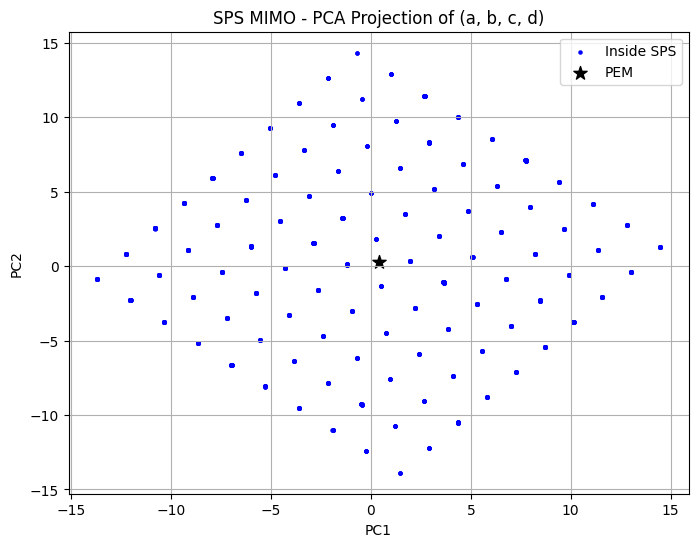

In [6]:
plot_sps_points(blue_pts, lse, mode='pca')

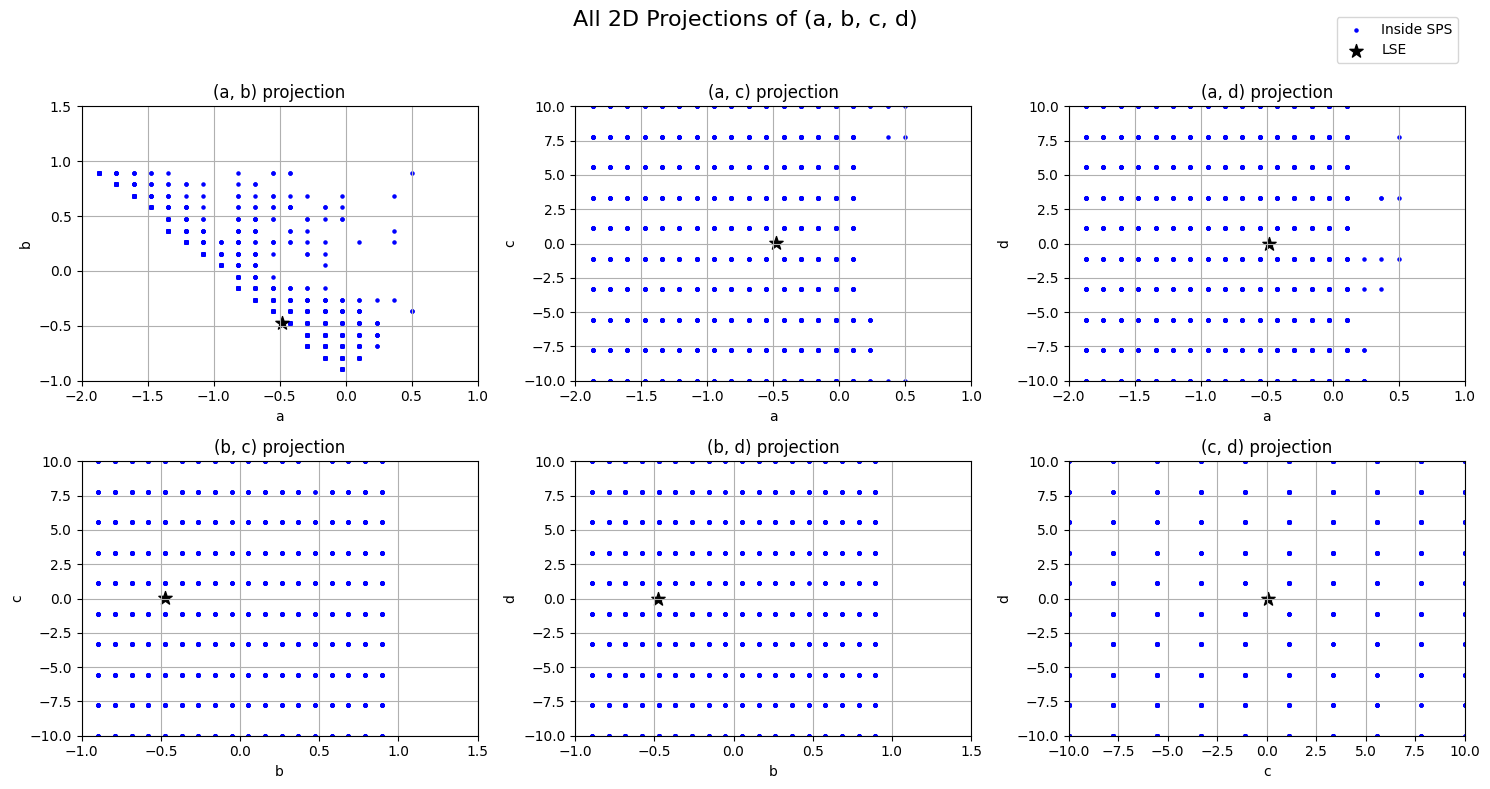

In [7]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

def plot_all_2d_projections(blue_pts, red_pts=None, lse=None, axis_limits=None):
    """
    Plot all 2D projections of (a, b, c, d) with optional axis limits.

    Parameters:
        blue_pts (np.ndarray): Points inside region, shape (N, 4)
        red_pts (np.ndarray or None): Optional outside points, shape (M, 4)
        lse (np.ndarray or None): Optional LSE point, shape (4,)
        axis_limits (dict or None): Optional axis limits, e.g. {'a': (-1, 1), 'd': (0, 2)}
    """
    blue_pts = np.asarray(blue_pts)
    if red_pts is not None:
        red_pts = np.asarray(red_pts)

    labels = ['a', 'b', 'c', 'd']
    pairs = list(combinations(range(4), 2))  # all unique 2D index pairs

    n_plots = len(pairs)
    n_cols = 3
    n_rows = int(np.ceil(n_plots / n_cols))

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))

    for ax, (i, j) in zip(axs.flat, pairs):
        ax.scatter(blue_pts[:, i], blue_pts[:, j], color='blue', s=5, label='Inside SPS')
        if red_pts is not None:
            ax.scatter(red_pts[:, i], red_pts[:, j], color='red', alpha=0.05, s=3, label='Outside SPS')
        if lse is not None:
            ax.scatter(lse[i], lse[j], color='black', marker='*', s=100, label='LSE')

        xi, xj = labels[i], labels[j]
        ax.set_xlabel(xi)
        ax.set_ylabel(xj)
        ax.set_title(f"({xi}, {xj}) projection")
        ax.grid(True)

        # Apply axis limits if provided
        if axis_limits:
            if xi in axis_limits:
                ax.set_xlim(axis_limits[xi])
            if xj in axis_limits:
                ax.set_ylim(axis_limits[xj])

    # Turn off any unused subplots
    for ax in axs.flat[n_plots:]:
        ax.axis('off')

    # Add legend and layout
    handles, legends = axs.flat[0].get_legend_handles_labels()
    fig.legend(handles, legends, loc='upper right', bbox_to_anchor=(0.98, 0.98))
    plt.suptitle("All 2D Projections of (a, b, c, d)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

axis_limits = {
    'a': (-2, 1),
    'b': (-1, 1.5),
    'c': (-10, 10),
    'd': (-10, 10)
}

plot_all_2d_projections(blue_pts, None, lse=lse, axis_limits=axis_limits)


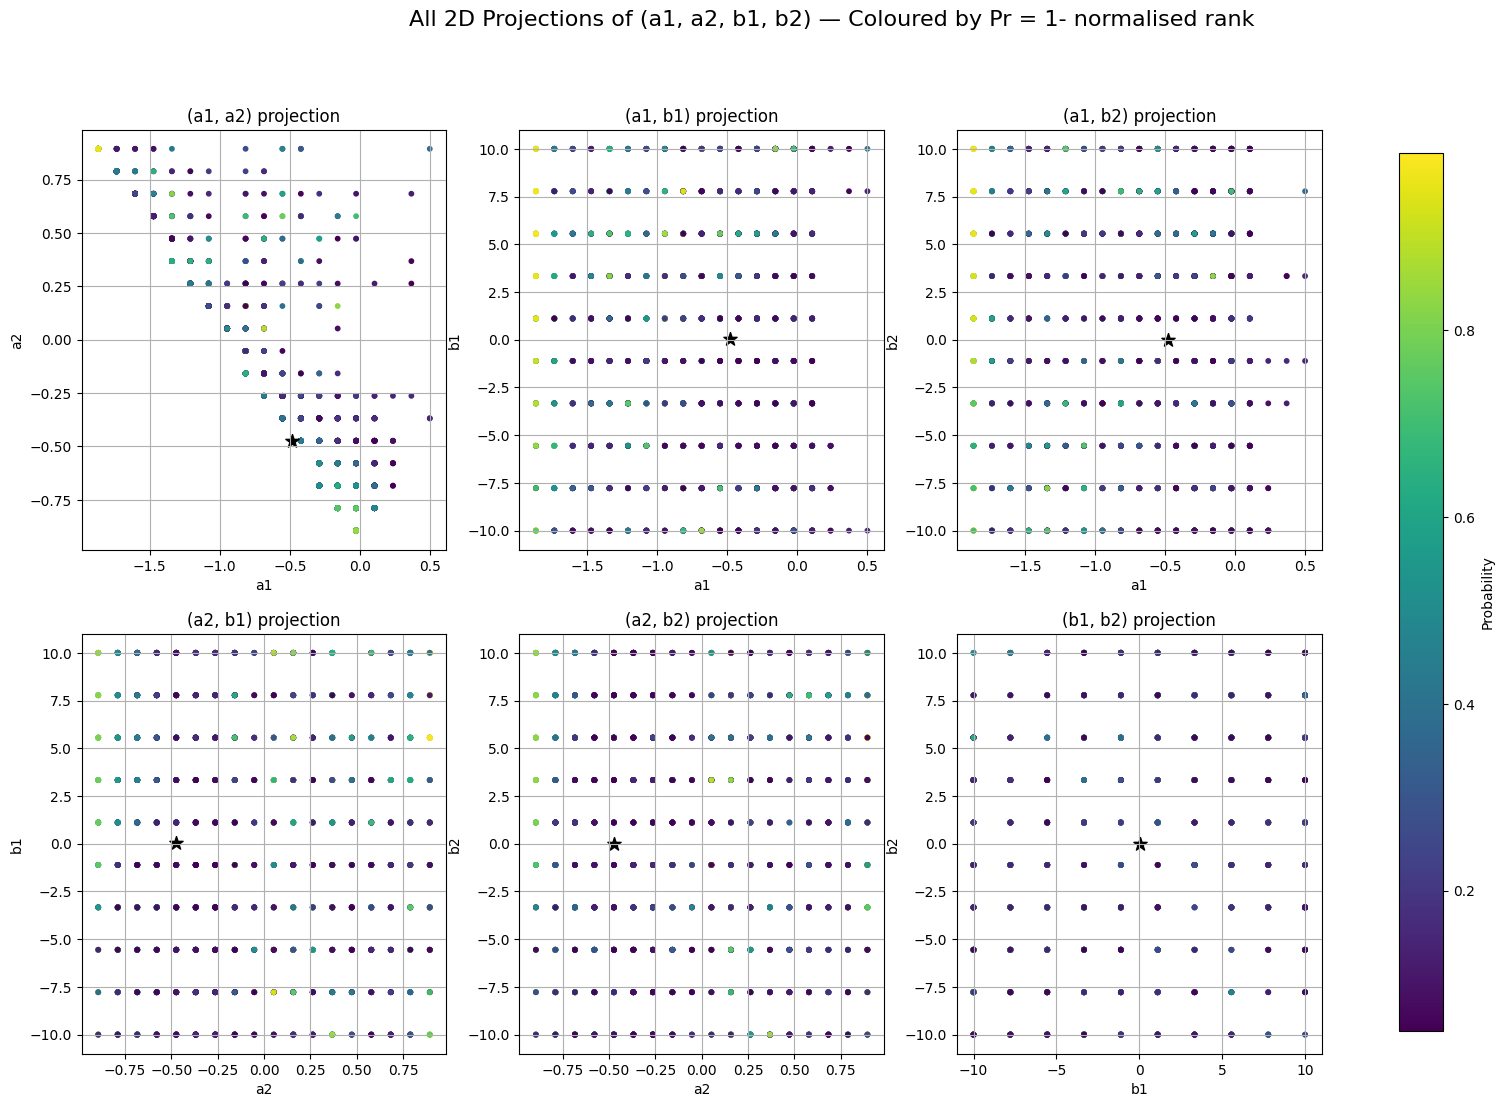

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

def plot_all_2d_projections_coloured(blue_pts, ranks, lse=None, axis_limits=None, cmap='viridis'):
    """
    Plot all 2D projections of (a1, a2, b1, b2), colouring blue_pts by given ranks.

    Parameters:
        blue_pts (np.ndarray): Points inside region, shape (N, 4)
        ranks (np.ndarray): Array of scalar values (e.g. probabilities) for each blue point, shape (N,)
        lse (np.ndarray or None): Optional LSE point, shape (4,)
        axis_limits (dict or None): Optional axis limits, e.g. {'a': (-1, 1), 'd': (0, 2)}
        cmap (str): Matplotlib colormap name
    """
    blue_pts = np.asarray(blue_pts)
    ranks = 1- np.asarray(ranks) # prob
    # Keep only points with ranks >= 0.5
    mask = ranks >= 0
    ranks = ranks[mask]
    blue_pts = blue_pts[mask]
    assert blue_pts.shape[0] == ranks.shape[0], "Ranks must match number of blue_pts"

    labels = ['a1', 'a2', 'b1', 'b2']
    pairs = list(combinations(range(4), 2))  # all 2D projections

    n_plots = len(pairs)
    n_cols = 3
    n_rows = int(np.ceil(n_plots / n_cols))

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * (n_cols +1), 4 * (n_rows+1)))
    norm = plt.Normalize(vmin=ranks.min(), vmax=ranks.max())

    for ax, (i, j) in zip(axs.flat, pairs):
        sc = ax.scatter(blue_pts[:, i], blue_pts[:, j], c=ranks, cmap=cmap, s=10, norm=norm)
        if lse is not None:
            ax.scatter(lse[i], lse[j], color='black', marker='*', s=100, label='LSE')

        xi, xj = labels[i], labels[j]
        ax.set_xlabel(xi)
        ax.set_ylabel(xj)
        ax.set_title(f"({xi}, {xj}) projection")
        ax.grid(True)

        if axis_limits:
            if xi in axis_limits:
                ax.set_xlim(axis_limits[xi])
            if xj in axis_limits:
                ax.set_ylim(axis_limits[xj])

    for ax in axs.flat[n_plots:]:
        ax.axis('off')

    cbar = fig.colorbar(sc, ax=axs.ravel().tolist(), shrink=0.95, label='Probability')
    plt.suptitle("All 2D Projections of (a1, a2, b1, b2) — Coloured by Pr = 1- normalised rank", fontsize=16)
    plt.show()
plot_all_2d_projections_coloured(blue_pts, ranks, lse=lse, axis_limits=axis_limits)


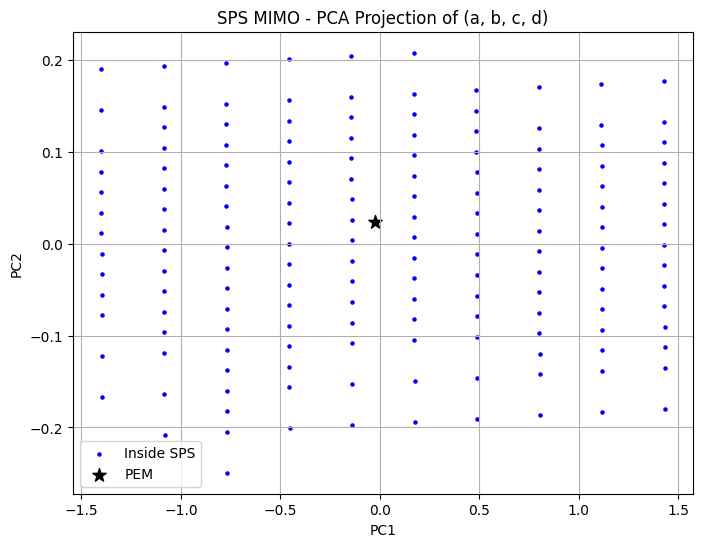

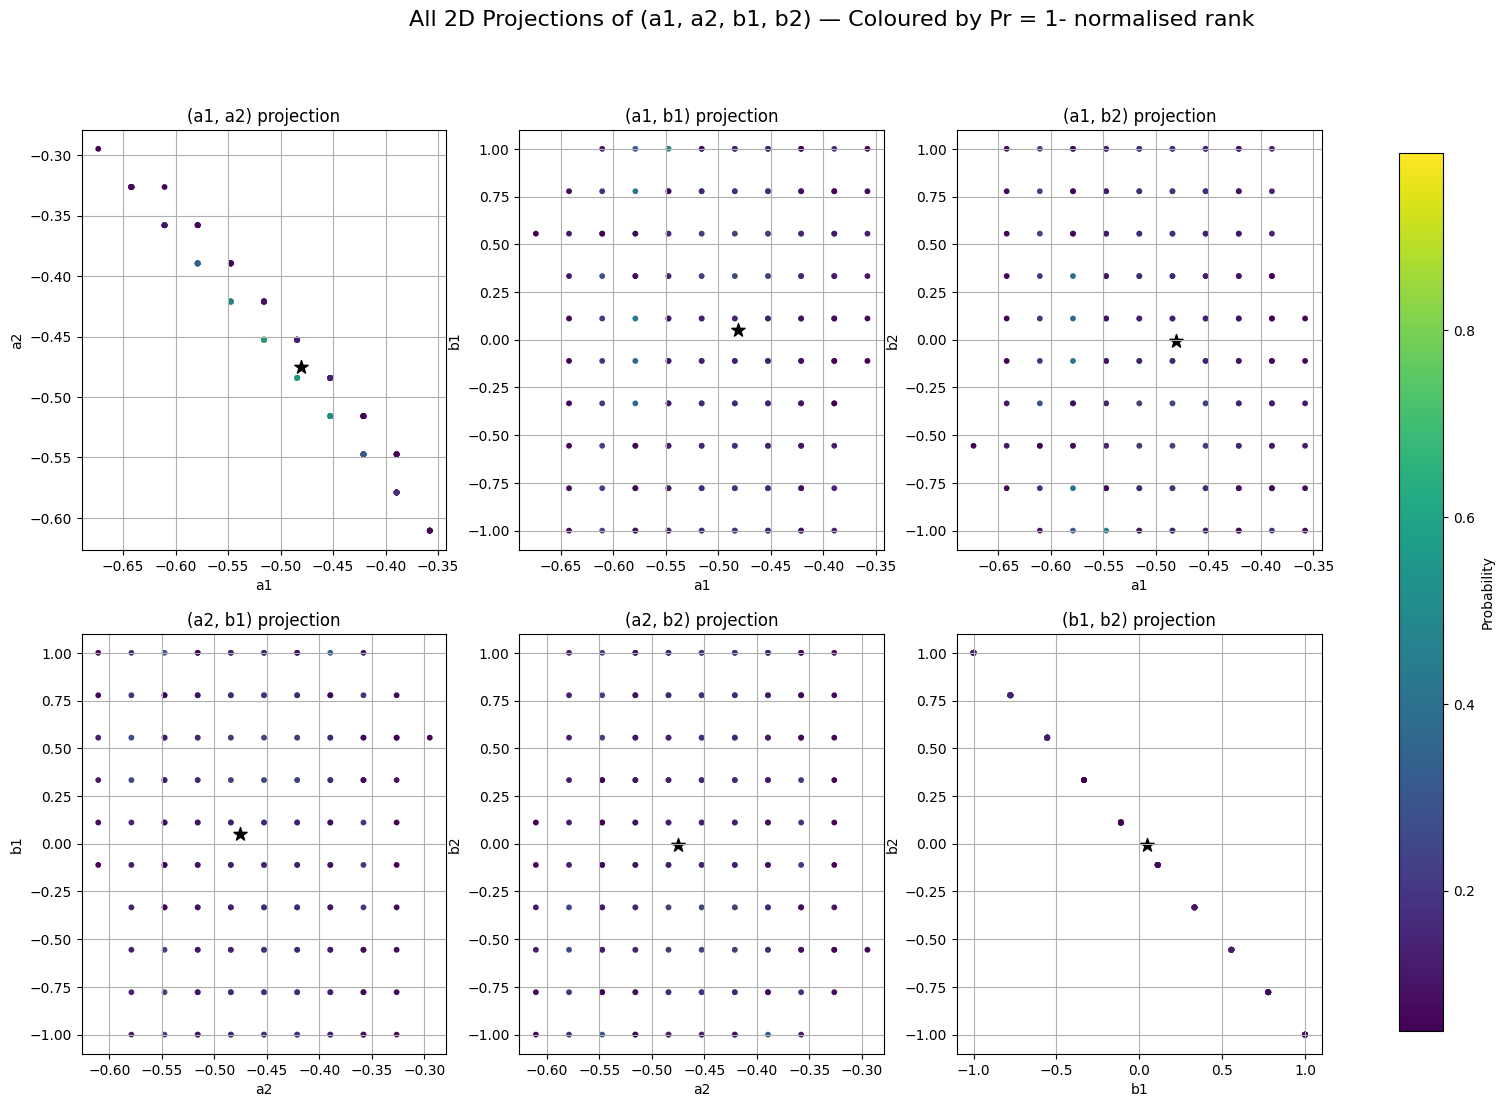

In [ ]:
model2  = SPS_indirect_model(m=m, q=q, N=N, 
                            n_states=2, n_inputs=1, n_outputs=1, 
                            n_noise=-1)
Y0 = Y[0,:].reshape(1, -1)
def is_inside_region2(point):
    try :
        A = np.array(point[:2])
        A = np.hstack([1, A])
        B = np.array(point[2:])
        B = np.hstack([0, B])
        G = d_tfs((B, A))
        if not _is_stable(A, epsilon=epsilon):
            return False, 1
        C = np.array([1.0])
        H = d_tfs((C, A))

        in_sps,rank = model2.sps_indicator(G=G, H=H, A=A, B=B, C=C,
                            Y_t = Y0, U_t=U.reshape(1,-1), sps_type=SPSType.OPEN_LOOP, return_rank=True)
    except Exception as e:
        print(f"Error in SPS check: {e}")
        in_sps = False
        rank = 1
    return in_sps, rank

# Grid resolution
a_vals = np.linspace(-0.8, -0.2, 20)
b_vals = np.linspace(-0.8, -0.2, 20)
c_vals = np.linspace(-1, 1, 10)
d_vals = np.linspace(-1, 1, 10)
blue_pts = []
ranks = []

for a in a_vals:
    for b in b_vals:
        for c in c_vals:
            for d in d_vals:
                point = np.array([a, b, c, d])
                in_sps, rank = is_inside_region2(point)
                if in_sps:
                    blue_pts.append([a, b, c, d])
                    ranks.append(rank)

blue_pts = np.array(blue_pts)
ranks = np.array(ranks)

plot_sps_points(blue_pts, lse, mode='pca')
plot_all_2d_projections_coloured(blue_pts, ranks, lse=lse, axis_limits=axis_limits)

# closed loop

In [12]:
blue_pts[:, :2].shape

(157, 2)

In [ ]:
from indirect_identification.sps_indirect import SPS_indirect_model
from numba import njit
from indirect_identification.d_tfs import d_tfs, apply_tf_matrix
from indirect_identification.tf_methods.fast_tfs_methods_fast_math import _is_stable
from dB.sim_db import SPSType
from scipy import optimize
from optimal_controller.optimal_controls import get_optimal_controller
from fusion.fusion import fuse, construct_p_tensor
import matplotlib.pyplot as plt

As = blue_pts[:, :2]
Bs = blue_pts[:, 2:]
Q = 0.4 * np.eye(1)
R = 1.2*np.eye(1)
K = get_optimal_controller(np.array(As), np.array(Bs), Q, R)
# U = FR - LU
print(K)

# from indirect_identification.armax import ARMAX
# from scipy.signal import lfilter, square
# import numpy as np
# # Example usage
# A = [1.0, 0.7]   # A(z^-1) = 1 - 0.33z^-1 - 0.1z^-2
# B = [0.4]       # B(z^-1) = 0.22z^-1 + 0.1z^-2
# C = [1.0]               # C(z^-1) = 1
# F = K[0]
# L = [F[0]*16]     # L(z^-1) = 1
# print(L)
# armax_model = ARMAX(A, B, C, F, L)

# n_samples = 500
# # square wave reference signal
# # R = square(np.linspace(0, 5*np.pi, n_samples)) + np.random.normal(0, 0.01, size=n_samples)
# R = np.sin(np.linspace(0, 10 * np.pi, n_samples)) 

# Y, U, N, R = armax_model.simulate(n_samples, R=R, noise_std=0.1)
# # armax_model.plot_results(Y, U, N, R)
# # get Y delayed by 1 sample
# Y_tm1 = lfilter([1, -1], [1], Y)
# Y = Y.reshape(1,-1)
# U = U.reshape(1,-1)
# R = R.reshape(1,-1)
# print(Y.shape, U.shape, R.shape)
